# Importing the required modules

In [1]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Modules used for preprocessing
from sklearn.preprocessing import StandardScaler

# Modules used for time series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modules used for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
import model

# Modules used for preprocessing
from datetime import datetime, timedelta, date
import preprocess
from model import Model

# Modules used for object oriented programming
from abc import ABC, abstractmethod

# Module for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

# For suppressing status messages from Facebook Prophet
import logging
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

# Consolidating the data

In [2]:
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered=True, stationary=False)
temperature = preprocess.preprocess("temperature")
precipitation = preprocess.preprocess("precipitation")

In [3]:
electricity = electricity.drop(pd.to_datetime("2015-01-01"))

In [4]:
weather = pd.merge(temperature, precipitation, on='date', how='inner').set_index("date")

In [5]:
weather = temperature.set_index("date")

# SARIMAX

In [ ]:
# class for SARIMAX model
class SARIMAX_model(Model):
    
    def __init__(self, data, exogs, cluster: str, window_stride = 28):
        """
         The constructor for the abstract class Model for standardize evaluation

         Args:
            data: the actual time series that needs to be predicted.
            exogs: the exogeneous variables particularly for SARIMAX.
            cluster: the cluster data which needs to be used (cluster_1 or cluster_0).
            window_stride: the stride (in days) for moving the train-test window; defaults to 28 days.

         Returns:
            - An object of abstract class SARIMA.
        """
        super().__init__(data, cluster, window_stride)
        self.exogs = exogs
    
    # trains the model
    def train_model(self, train, train_idx):
        model = SARIMAX(endog = train[self.cluster], 
                        exog = self.exogs[train_idx[0]: train_idx[1]], 
                        order = (1, 1, 1), 
                        seasonal_order = (1, 1, 0, 12))
        return model.fit()
    
     # obtains the forecasts for next five time steps
    def get_forecasts_(self, test_idx):
        return self.trained_model.forecast(steps = 5, exog = self.exogs[test_idx[0]: test_idx[1]])
    
    # obtains the forecasts for next five time steps
    def get_forecasts(self, test, test_idx):
        return self.trained_model.predict(start = self.data.index[test_idx[0]], 
                                        end = self.data.index[test_idx[0]] + timedelta(len(test) - 1),
                                        exog = self.exogs[test_idx[0]: test_idx[1]])
    

In [16]:
m = SARIMAX_model(np.log(electricity), weather, "cluster_1")

In [17]:
m.cross_validate()

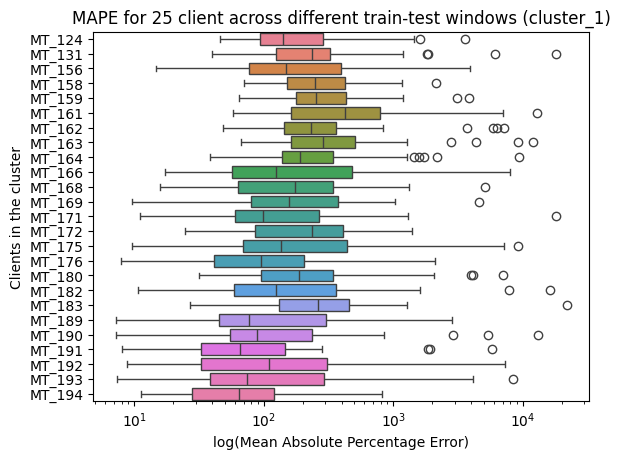

In [18]:
m.mape_boxplot_by_client(25)

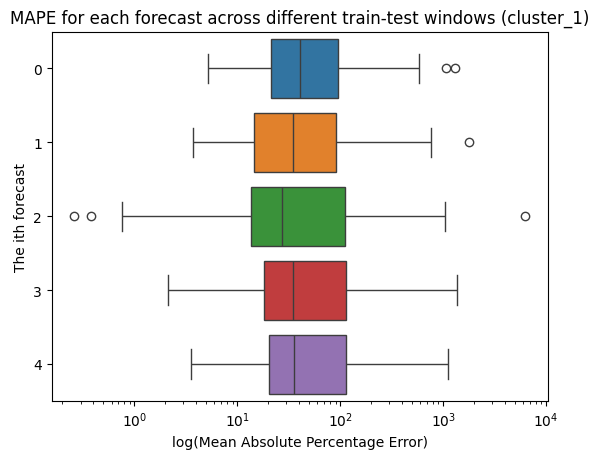

In [19]:
m.mape_boxplot_by_step()

In [20]:
t = dict()
for i in m.forecasts:
    t[i] = m.forecasts[i]["mape_by_forecast"]

df = pd.DataFrame.from_dict(t, orient = "index")
df.describe()

,0,1,2,3,4
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,133.344983,111.699609,232.402865,121.127802,103.815674
std,253.590783,273.998814,911.437078,238.056083,175.654632
min,5.196613,3.725242,0.260515,2.138722,3.573484
25%,21.460238,14.537384,13.648161,18.073903,20.171154
50%,40.864384,34.587986,27.246497,34.987984,35.205652
75%,94.878009,91.982727,111.186550,113.680003,115.141334
max,1306.851096,1767.885215,6254.557889,1353.448886,1109.757343


In [21]:
m = SARIMAX_model(electricity, weather, "cluster_0")

In [22]:
m.cross_validate()

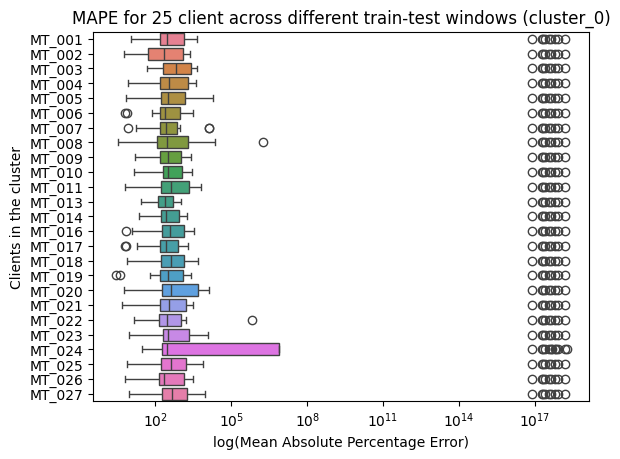

In [23]:
m.mape_boxplot_by_client(25)

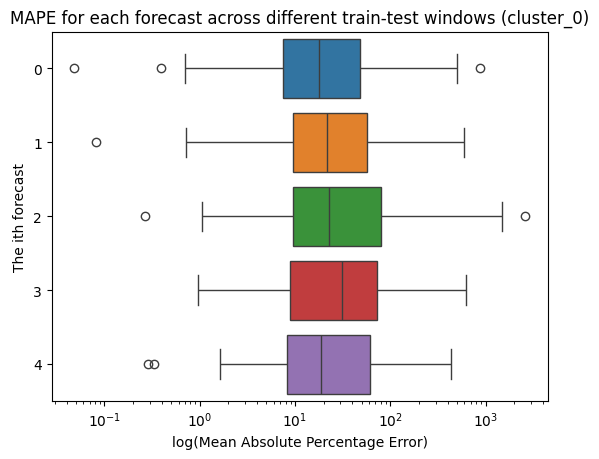

In [24]:
m.mape_boxplot_by_step()

In [25]:
t = dict()
for i in m.forecasts:
    t[i] = m.forecasts[i]["mape_by_forecast"]

df = pd.DataFrame.from_dict(t, orient = "index")
df.describe()

,0,1,2,3,4
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,67.474922,62.985307,180.087515,66.042753,57.692387
std,151.891591,115.336977,481.712736,112.219299,93.908981
min,0.048145,0.081733,0.267557,0.971318,0.285928
25%,7.557843,9.512666,9.610179,8.806592,8.335126
50%,18.148840,21.867385,22.727605,30.884722,18.954658
75%,48.026489,57.691979,79.472136,72.953514,61.679840
max,885.884505,588.148713,2602.775285,624.397825,431.338620


# Facebook Prophet

In [6]:
import prophet

In [7]:
%load_ext autoreload
%autoreload 2

In [49]:
class FacebookProphet_model(Model):
    
    def __init__(self, exogs, data, cluster, window_stride=28, ts_train=182, ts_test=6, holidays=True):
        super().__init__(data, cluster, window_stride, ts_train, ts_test)
        self.exogs = exogs
        self.holidays = holidays

    def restructure(self, df):
        df = df.reset_index()
        df["date"] = pd.to_datetime(df["date"])
        df = df.merge(self.exogs.reset_index())
        df = df.rename({"date": "ds", self.cluster:"y"}, axis=1)
        return df

    def train_model(self, train, train_idx):
        model = prophet.Prophet()
        for col in self.exogs.columns:
                model.add_regressor(col)

        if self.holidays:
            # Add Portugal holidays - helps catch outliers around New Year
            model.add_country_holidays(country_name='Portugal')
        
        #print(train.columns, self.exogs.columns)
        train = self.restructure(train)
        return model.fit(train.reset_index())
    
    def get_forecasts(self, test, test_idx):

        df = self.trained_model.make_future_dataframe(periods = self.ts_test)

        df = self.restructure(df.rename({"ds": "date"}, axis = 1)).drop(["index"], axis = 1)

        #print(test_idx[0], test_idx[0] + self.ts_test)

        return self.trained_model.predict(df)["yhat"][self.ts_train:self.ts_train + self.ts_test]

    # Plot the results of each forecast
    def train_plot(self, n_forecast):
        diff = n_forecast*self.ts_window_stride
        train_idx = [min(diff, self.MAX_IDX), min(self.ts_train + diff, self.MAX_IDX)]
        test_idx = [min(self.ts_train + diff, self.MAX_IDX), min(self.ts_train + self.ts_test + diff, self.MAX_IDX)]
        
        train = self.data[train_idx[0]: train_idx[1]][[self.cluster]]
        test = self.data[test_idx[0]: test_idx[1]][[self.cluster]]

        # standardizing the train and test data
        train_std, test_std = self.standardize(train, test)

        # training the model
        self.trained_model = self.train_model(train_std, train_idx)

        plt.scatter(train.reset_index()['date'], train[self.cluster]/4, c='b')
        plt.scatter(test.reset_index()['date'], test[self.cluster]/4, c='r')
        
        df = self.trained_model.make_future_dataframe(periods = self.ts_test)

        df = self.restructure(df.rename({"ds": "date"}, axis = 1)).drop(["index"], axis = 1)

        forecast = self.trained_model.predict(df)[['ds', 'yhat']]

        # Destandardize for visualization
        forecast_std = self.destandardize(forecast[['yhat']])

        plt.plot(forecast['ds'], forecast_std/4, '-k')
        plt.xlabel('Date')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Total electricity consumption, kWh')
        plt.legend(['Train actual', 'Test actual', 'Prediction'])

In [13]:
m = FacebookProphet_model(weather, electricity, "cluster_0")

In [14]:
m.cross_validate()

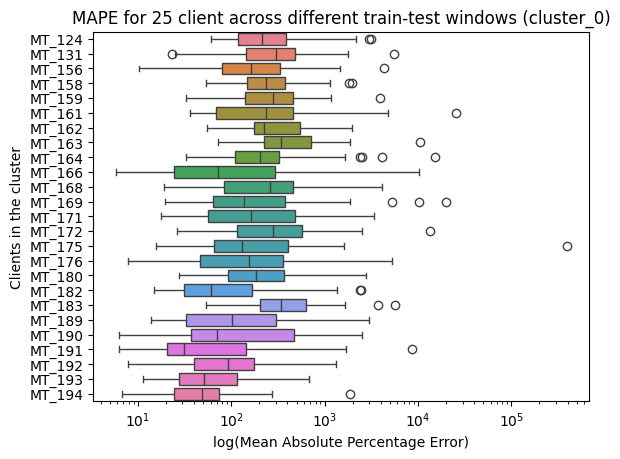

In [11]:
m.mape_boxplot_by_client(25)

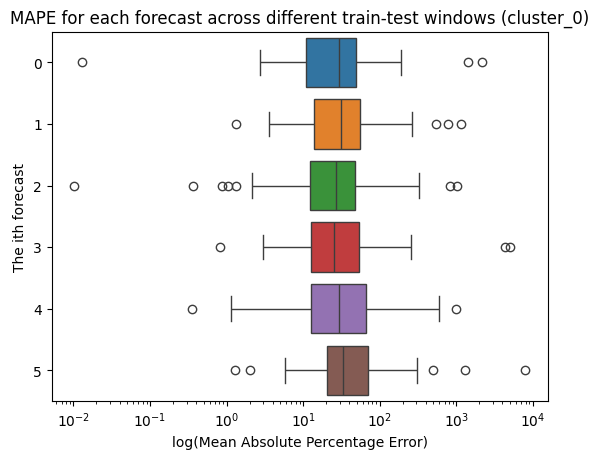

In [15]:
m.mape_boxplot_by_step()

In [28]:
m = FacebookProphet_model(weather, electricity.loc[date(2012, 1, 1):,:], "cluster_1")

In [29]:
m.cross_validate()

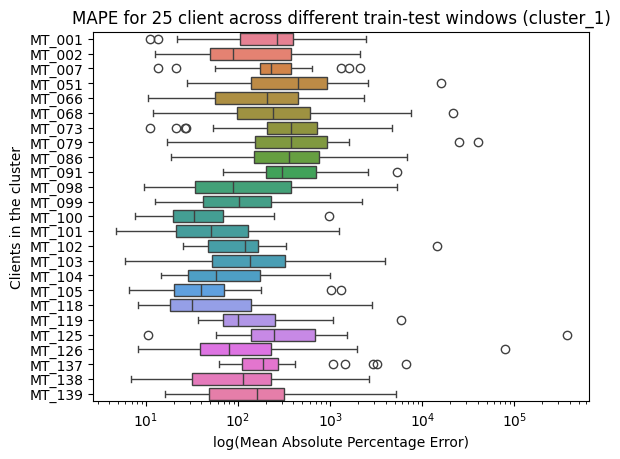

In [30]:
m.mape_boxplot_by_client(25)

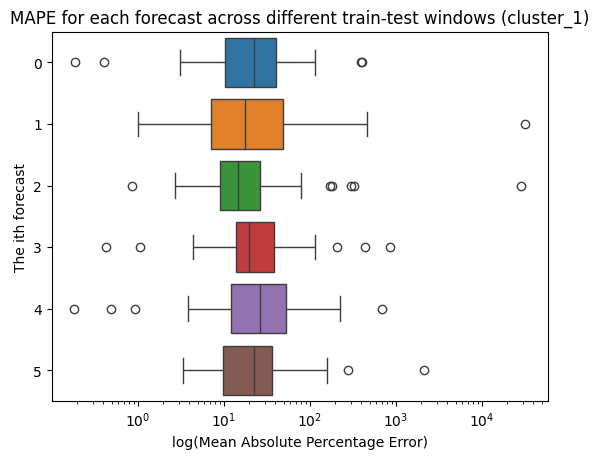

In [31]:
m.mape_boxplot_by_step()

In [53]:
m = FacebookProphet_model(weather, electricity.loc[date(2012, 1, 1):,:], "cluster_2")

In [54]:
m.cross_validate()

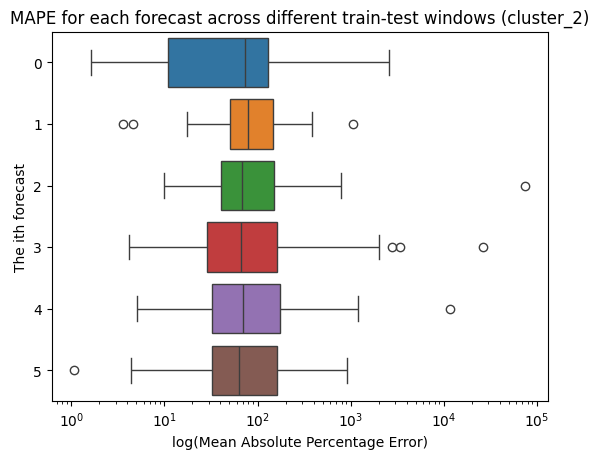

In [55]:
m.mape_boxplot_by_step()

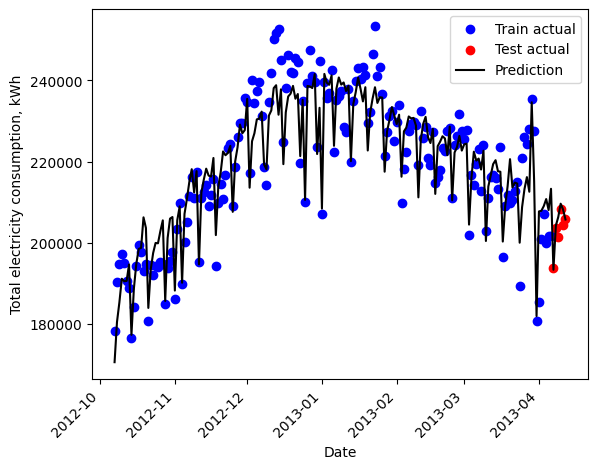

In [36]:
m.train_plot(10)

In [37]:
m = FacebookProphet_model(weather, electricity.loc[date(2012, 1, 1):,:], "cluster_3")

In [38]:
m.cross_validate()

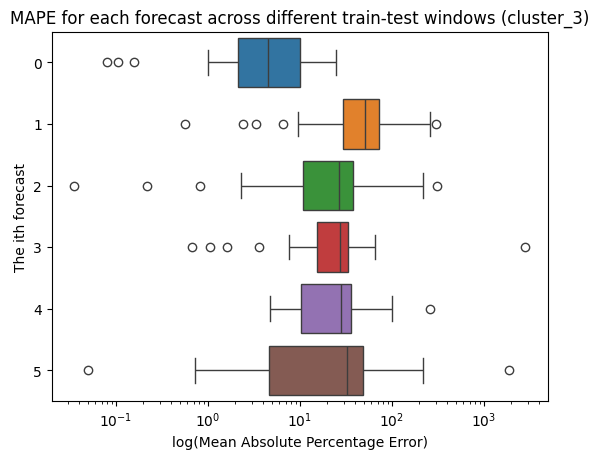

In [39]:
m.mape_boxplot_by_step()

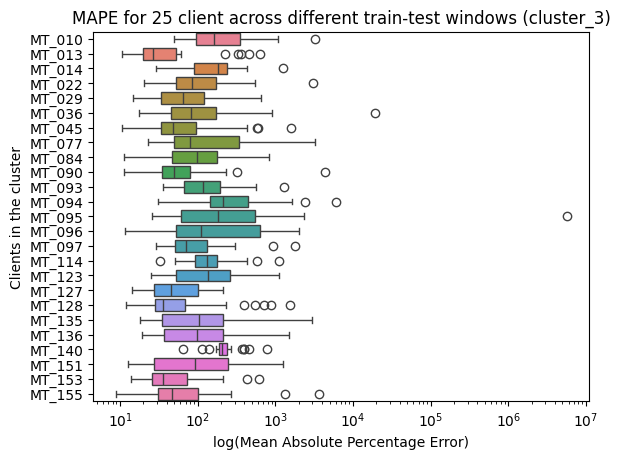

In [40]:
m.mape_boxplot_by_client(25)

In [41]:
m = FacebookProphet_model(weather, electricity.loc[date(2012, 1, 1):,:], "cluster_4")

In [42]:
m.cross_validate()

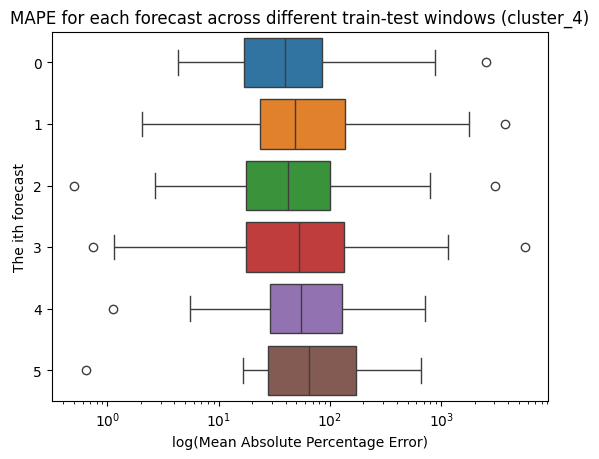

In [43]:
m.mape_boxplot_by_step()

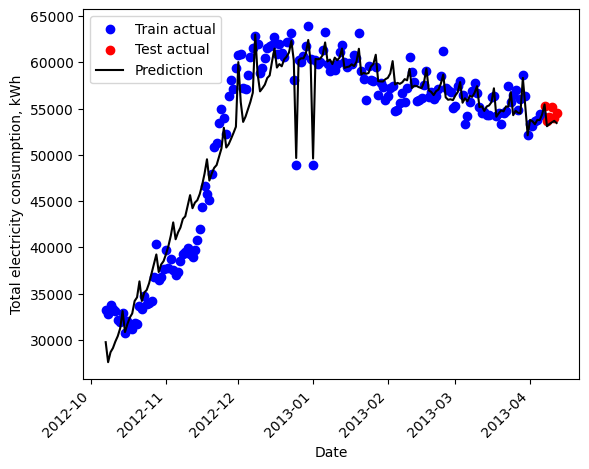

In [44]:
m.train_plot(10)

Increasing train period:

In [45]:
m = FacebookProphet_model(weather, electricity.loc[date(2012, 1, 1):,:], "cluster_2", ts_train = 730)

In [46]:
m.cross_validate()

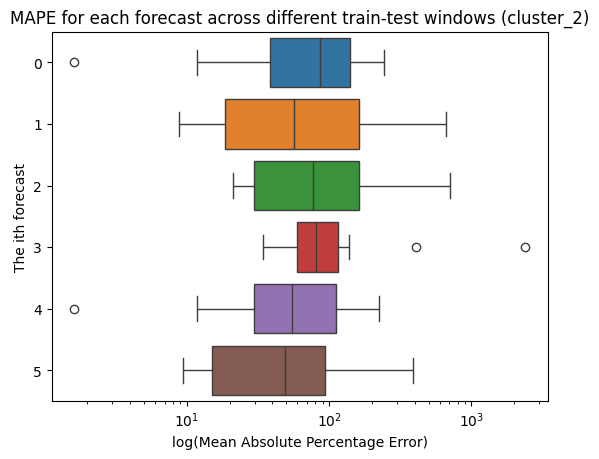

In [47]:
m.mape_boxplot_by_step()

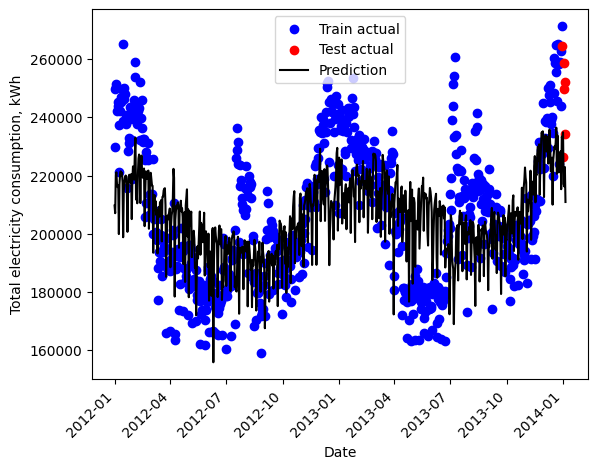

In [48]:
m.train_plot(0)